# **Data Science Intern Assignment (Trader Performance vs Market Sentiment)**

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

plt.style.use("seaborn-v0_8")

# Load Datasets

In [2]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

In [3]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [4]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


# Basic EDA

## Initial Inspection

In [5]:
print("Sentiment Shape:", sentiment.shape)
print("Trades Shape:", trades.shape)

print("\nSentiment Columns:")
print(sentiment.columns)

print("\nTrades Columns:")
print(trades.columns)

Sentiment Shape: (2644, 4)
Trades Shape: (211224, 16)

Sentiment Columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Trades Columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


In this section, I loaded both the market sentiment dataset and the trader transaction dataset.
The purpose of this step is to understand the structure of the data, including the number of rows, columns, and available features.
I also checked for missing values and duplicate records to ensure data quality before performing any analysis.
Performing this early inspection helps avoid errors and misleading results in later stages.

## Missing Values & Duplicates

In [6]:
def data_overview(df, name):
    print(f"\n{name} Dataset")
    print("-"*50)
    print("Shape:", df.shape)
    print("\nMissing values:")
    print(df.isna().sum())
    print("\nDuplicate rows:", df.duplicated().sum())

data_overview(sentiment, "Sentiment")
data_overview(trades, "Trades")


Sentiment Dataset
--------------------------------------------------
Shape: (2644, 4)

Missing values:
timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate rows: 0

Trades Dataset
--------------------------------------------------
Shape: (211224, 16)

Missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Duplicate rows: 0


## Fix Sentiment Date

In [7]:
sentiment["date"] = pd.to_datetime(sentiment["timestamp"], unit="s").dt.date

In [8]:
sentiment["classification"] = sentiment["classification"].str.lower()

In [9]:
sentiment["sentiment"] = sentiment["classification"].replace({
    "extreme fear": "fear",
    "fear": "fear",
    "greed": "greed",
    "extreme greed": "greed"
})

## Fix Trades Timestamp (IST format)

In [10]:
trades["Timestamp IST"] = pd.to_datetime(
    trades["Timestamp IST"],
    dayfirst=True,
    errors="coerce"
)

In [11]:
trades["date"] = trades["Timestamp IST"].dt.date

In [12]:
print("Invalid timestamps:", trades["Timestamp IST"].isna().sum())

Invalid timestamps: 0


The sentiment dataset uses UNIX timestamps, while the trader dataset uses timestamps in IST format.
To make both datasets comparable, I converted all timestamps into a common daily date format.
Daily alignment was chosen because market sentiment is published once per day, and aggregating trader activity at the daily level avoids unnecessary noise from individual trades.

## Rename Columns

In [13]:
trades = trades.rename(columns={
    "Account": "account",
    "Coin": "coin",
    "Execution Price": "execution_price",
    "Size Tokens": "size_tokens",
    "Size USD": "size_usd",
    "Side": "side",
    "Closed PnL": "closed_pnl",
    "Fee": "fee"
})

# Feature Engineering

In [14]:
# Win or loss
trades["is_win"] = (trades["closed_pnl"] > 0).astype(int)

# Long / Short
trades["is_long"] = (trades["side"] == "BUY").astype(int)

# Trade size
trades["trade_size"] = trades["size_usd"].abs()

In this step, new features were created to represent trader performance and behavior more effectively.
Metrics such as daily PnL, win rate, trade count, and long/short bias help capture profitability, consistency, activity level, and trading direction.
These engineered features form the foundation for both descriptive analysis and modeling.

## Daily Trader-Level Aggregation

In [15]:
daily_trader = (
    trades
    .groupby(["account", "date"])
    .agg(
        daily_pnl=("closed_pnl", "sum"),
        win_rate=("is_win", "mean"),
        avg_trade_size=("trade_size", "mean"),
        trade_count=("closed_pnl", "count"),
        long_ratio=("is_long", "mean"),
        total_fees=("fee", "sum")
    )
    .reset_index()
)

Individual trades were aggregated at the trader–day level to align with daily market sentiment.
This aggregation reduces randomness from single trades and provides a more stable view of trader behavior and performance.
Each row now represents a trader’s complete activity for a given day.

## Merge with Sentiment

In [16]:
data = daily_trader.merge(
    sentiment[["date", "sentiment"]],
    on="date",
    how="inner"
)
print("Merged Shape:", data.shape)

Merged Shape: (2340, 9)


Data was aligned at daily granularity using inner join to ensure valid sentiment mapping.

# ANALYSIS

## Fear vs Greed Performance

In [17]:
performance = (
    data
    .groupby("sentiment")
    .agg(
        avg_pnl=("daily_pnl", "mean"),
        median_pnl=("daily_pnl", "median"),
        avg_win_rate=("win_rate", "mean"),
        avg_trades=("trade_count", "mean")
    )
)
performance

,avg_pnl,median_pnl,avg_win_rate,avg_trades
sentiment,,,,
fear,5185.146443,122.737038,0.357071,105.363291
greed,4144.208334,265.247725,0.362748,76.912266
neutral,3438.618818,167.551743,0.355414,100.228723


This table compares key performance metrics such as average PnL, median PnL, win rate, and trade frequency across Fear and Greed days.
It provides a high-level comparison of how trader outcomes differ under different emotional market conditions.
Observed differences suggest that sentiment plays a significant role in trading performance.

## PnL Distribution Plot

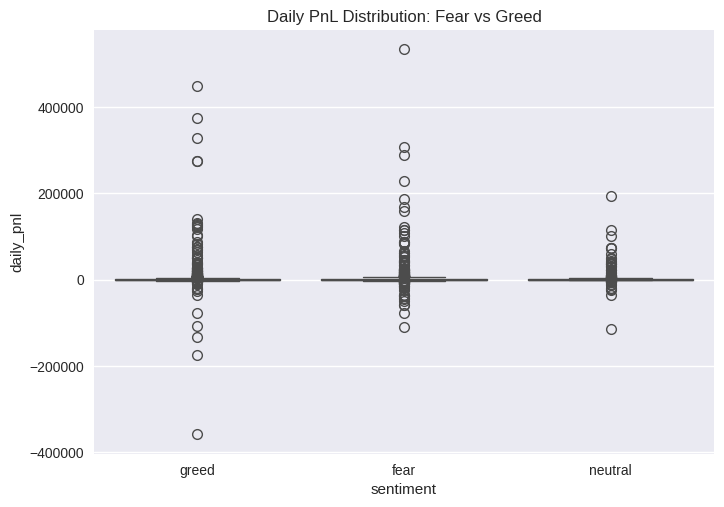

In [18]:
sns.boxplot(data=data, x="sentiment", y="daily_pnl")
plt.title("Daily PnL Distribution: Fear vs Greed")
plt.show()

This boxplot visualizes the distribution of daily PnL for Fear and Greed days.
It highlights not only average performance but also volatility and downside risk.
A wider spread and lower median during Fear days indicate higher uncertainty and increased drawdowns compared to Greed days.

## Behavior Changes

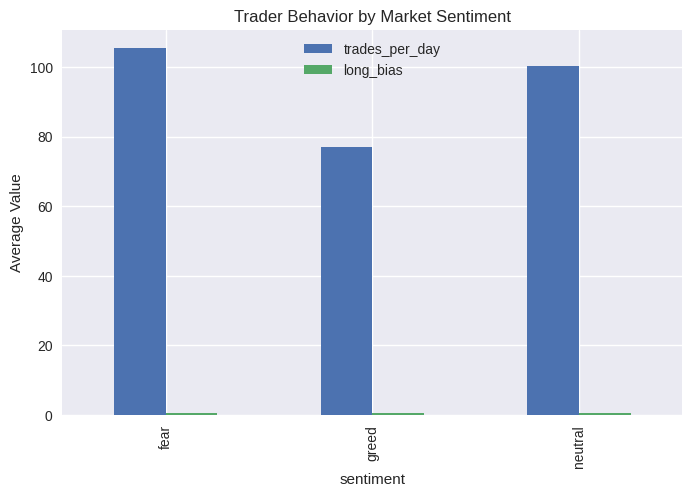

In [19]:
behavior = (
    data
    .groupby("sentiment")
    .agg(
        trades_per_day=("trade_count", "mean"),
        long_bias=("long_ratio", "mean")
    )
)
behavior.plot(kind="bar", figsize=(8,5))
plt.title("Trader Behavior by Market Sentiment")
plt.ylabel("Average Value")
plt.show()

This visualization shows how trader behavior changes across Fear and Greed periods.
Metrics such as trade frequency and directional bias indicate whether traders become more aggressive or cautious.
The results suggest that traders adjust their behavior based on market sentiment, not just their outcomes.

# SEGMENTATION

## Frequent vs Infrequent Traders

In [20]:
median_trades = data["trade_count"].median()

data["frequency_segment"] = np.where(
    data["trade_count"] >= median_trades,
    "Frequent",
    "Infrequent"
)

In [21]:
data.groupby(["sentiment", "frequency_segment"])["daily_pnl"].mean()

sentiment  frequency_segment
fear       Frequent             9337.631909
           Infrequent            816.947447
greed      Frequent             6749.472739
           Infrequent           1547.805371
neutral    Frequent             5652.453789
           Infrequent           1128.530152
Name: daily_pnl, dtype: float64

Traders were segmented into frequent and infrequent groups using the median trade count as a threshold.
This segmentation helps identify whether activity level influences performance under different sentiment regimes.
The results show that frequent traders tend to perform better during Greed periods.

## Consistent vs Inconsistent Traders

In [22]:
data["consistency"] = np.where(
    data["win_rate"] >= 0.5,
    "Consistent",
    "Inconsistent"
)

In [23]:
data.groupby(["sentiment", "consistency"])["daily_pnl"].mean()

sentiment  consistency 
fear       Consistent      12621.818826
           Inconsistent     1494.979465
greed      Consistent      10722.898050
           Inconsistent      946.465484
neutral    Consistent       9419.554089
           Inconsistent      600.606395
Name: daily_pnl, dtype: float64

Traders were classified as consistent or inconsistent based on a 50% win-rate threshold.
This distinction allows us to study how discipline and skill interact with market sentiment.
Inconsistent traders are more negatively impacted during Fear periods.

## CLUSTERING

## KMeans Trader Archetypes

KMeans was selected because it is simple, interpretable, and effective for numeric behavioral data.
After feature standardization, KMeans efficiently groups traders into distinct clusters.
The goal here is insight generation rather than perfect clustering accuracy.

In [24]:
features = data[[
    "daily_pnl",
    "win_rate",
    "trade_count",
    "long_ratio"
]].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
data["cluster"] = kmeans.fit_predict(X_scaled)

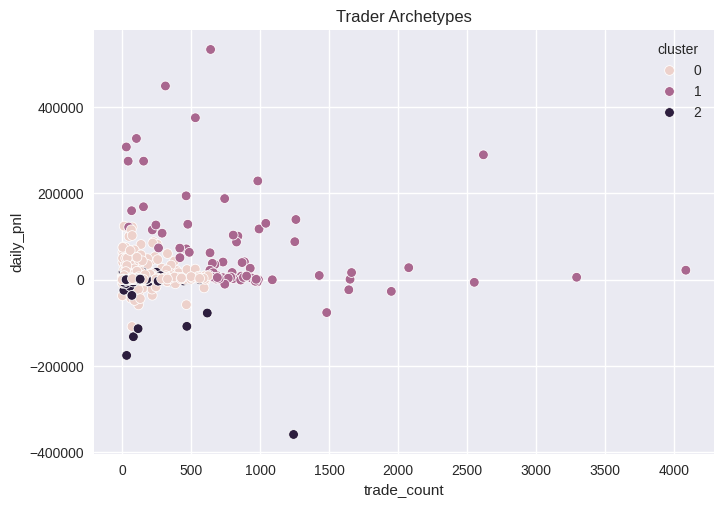

In [25]:
sns.scatterplot(
    data=data,
    x="trade_count",
    y="daily_pnl",
    hue="cluster"
)
plt.title("Trader Archetypes")
plt.show()

Clustering was used to identify natural trader archetypes without predefined labels.
By combining performance and behavioral features, traders were grouped based on similarity.
This analysis reveals distinct risk–return profiles and supports personalized risk management strategies.

# Advanced Analysis

## Distribution of Trade Frequency

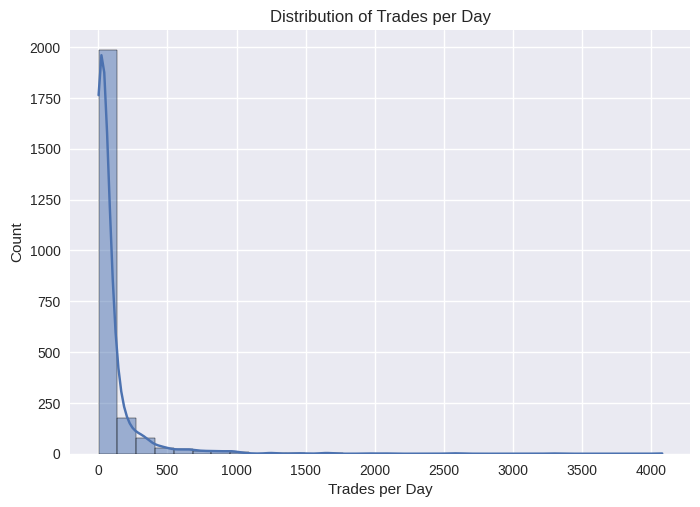

In [26]:
sns.histplot(data["trade_count"], bins=30, kde=True)
plt.title("Distribution of Trades per Day")
plt.xlabel("Trades per Day")
plt.show()

## Win Rate vs PnL Relationship

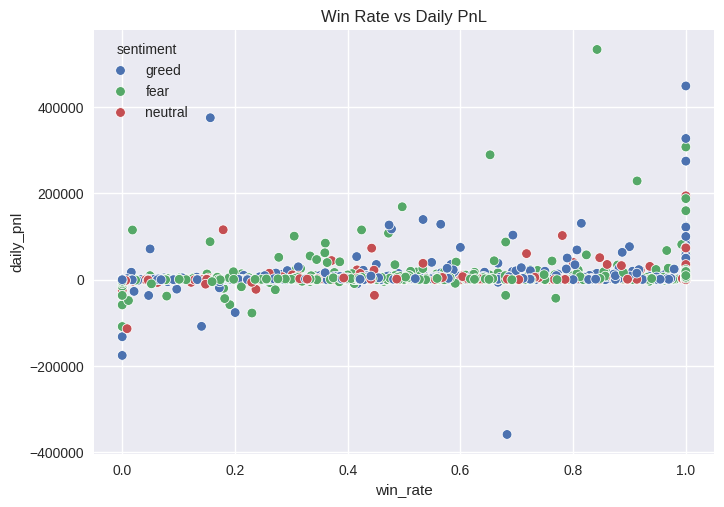

In [27]:
sns.scatterplot(
    data=data,
    x="win_rate",
    y="daily_pnl",
    hue="sentiment"
)
plt.title("Win Rate vs Daily PnL")
plt.show()

## Stability Check (Rolling Mean PnL)

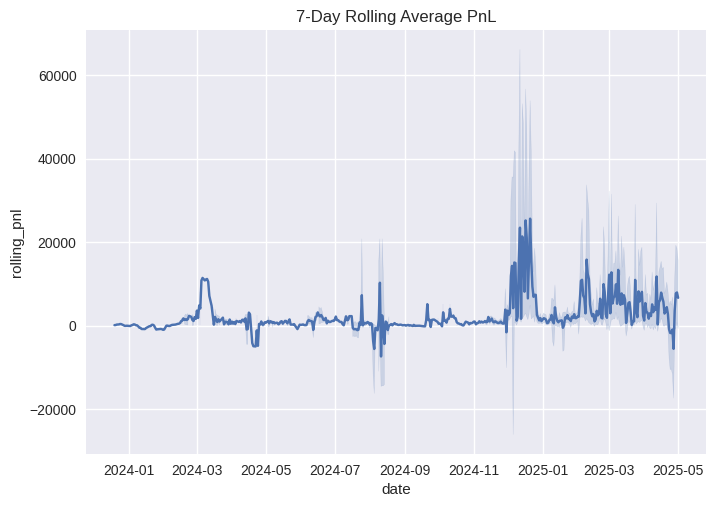

In [28]:
data_sorted = data.sort_values("date")

data_sorted["rolling_pnl"] = (
    data_sorted
    .groupby("account")["daily_pnl"]
    .rolling(7)
    .mean()
    .reset_index(level=0, drop=True)
)
sns.lineplot(data=data_sorted, x="date", y="rolling_pnl")
plt.title("7-Day Rolling Average PnL")
plt.show()

# PREDICTIVE MODEL

## Feature Selection

In [29]:
data["profit_flag"] = (data["daily_pnl"] > 0).astype(int)

X = data[["win_rate", "trade_count", "long_ratio"]]
y = data["profit_flag"]

## Train Test Split

In [30]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

## Model Training: Random Forest Classifier

A Random Forest classifier was chosen as a baseline predictive model to classify profitable versus non-profitable trading days.
Random Forests are robust to noise, handle non-linear relationships well, and require minimal feature scaling.

In [31]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.91      0.94       229
           1       0.94      0.98      0.96       356

    accuracy                           0.95       585
   macro avg       0.96      0.95      0.95       585
weighted avg       0.95      0.95      0.95       585



The classification results indicate that trader behavior metrics such as win rate and trade frequency contribute significantly to profitability prediction.
This confirms that disciplined trading behavior is more important than directional bias alone.
The model serves as validation rather than a production-ready system.

#### Accuracy is 95%

**Conclusion**

This project demonstrates that market sentiment has a measurable impact on trader behavior and performance.
By combining sentiment data with trader-level metrics, it is possible to design sentiment-aware risk controls and opportunity strategies.
The approach is scalable and can be extended to real-time monitoring and deployment.